<a href="https://colab.research.google.com/github/cu-applied-math/appm-4600-numerics/blob/main/Demos/Ch1_QuadraticFormula.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Condition numbers and algorithms for the quadratic formula
Demo by Stephen Becker, released under BSD 3-clause license

## Condition number
If $r_-$ and $r_+$ are the roots, then we derived in our lecture that the condition number of finding the root $r$, with respect to perturbations in the coefficient $a$ (using $p(x) = ax^2 + bx + c$) is
$$
\kappa(a) = \left| \frac{r}{r_+-r_-} \right|
$$
so if the absolute value of a root $|r|$ is much greater than the spacing between the roots $|r_+-r_-|$, then root finding becomes ill-conditioned.

Below is an example



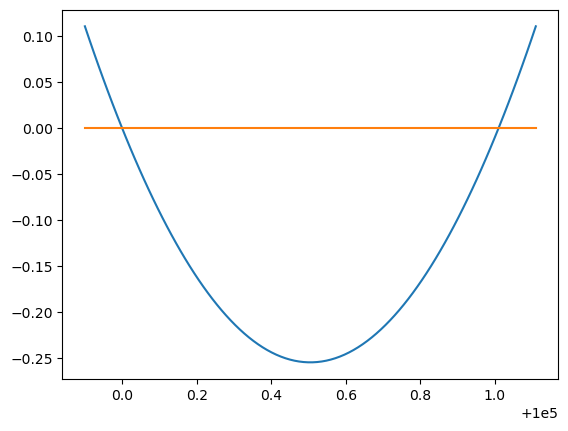

In [3]:
import math
import numpy as np
from matplotlib import pyplot as plt

def myRoots( a, b, c):
  """ convention: returns roots in ascending order """
  discSq = math.sqrt( b*b - 4*a*c)
  return (-b - discSq)/(2*a) , (-b + discSq)/(2*a)

# Make a polynomial
rm = 1e5
rp = rm + 1.01
a , b, c = 1., -(rm+rp), rm*rp

# Make some plots of that polynomial
from numpy.polynomial import polynomial as P
p = P.Polynomial((c,b,a))
# Let's zoom in
xGrid = np.linspace(rm-.1,rp+.1,100)
plt.plot( xGrid, p(xGrid) )
plt.plot( (rm-.1,rp+.1), (0,0))
plt.show()

Let's try to find the roots using our function

In [4]:
sm, sp = myRoots( a, b, c)
print( "Relative Error is {:e} and {:e}".format(abs(sm-rm)/abs(rm), abs(sp-rp)/abs(rp)) )

Relative Error is 8.550851e-12 and 8.550910e-12


The error in our input is about $10^{-16}$ due to floating point, and then we have a condition number of about $10^5$ with respect to the coefficient $a$, so we should lose at least 5 digits, and expect an answer no more accurate than $10^{-11}$.   There's *nothing we can do about this*.


In fact, it's could be even worse, because we have to take into account error from $b$ and $c$, as well as the implementation of the root-finding is not perfect (more about that shortly!)

Below is an example of a polynomial that is well-conditioned, yet we still lose a few digits. Why? Because in this case, our algorithm isn't as stable as it could be:

In [5]:
rm = 1.1
rp = 1.1e9
a , b, c = 1., -(rm+rp), rm*rp

s1, s2 = myRoots( a, b, c)
print( "Relative Error is {:.2e} and {:.2e}".format(abs(sm-rm)/abs(rm), abs(sp-rp)/abs(rp)) )

Relative Error is 9.09e+04 and 1.00e+00


## Changing the algorithm
For more accuracy, we must re-examine our use of the quadratic formula.  Supposing $b>0$, then when we use the formula
$$
r_+ = \frac{ - b + \sqrt{b^2 - 4ac} }{2a}
$$
then if $b^2 \gg 4ac$, we have $\sqrt{b^2 - 4ac} \approx b$, and so we'll have **subtractive cancellation** and lose precision.

Instead, rationalize the numerator,
$$
r_+ = \frac{ - b + \sqrt{b^2 - 4ac} }{2a} \cdot
\frac{ - b - \sqrt{b^2 - 4ac} }{- b - \sqrt{b^2 - 4ac}}
= \frac{ b^2 - (b^2 - 4ac)}{ 2a(-b-\sqrt{b^2 - 4ac} )}
$$
and then cancel the $b^2 - b^2$ **by hand** in the numerator (rather than relying on the computer to do it) and simplify to get
$$ r_+ = \frac{-2c}{b+\sqrt{b^2-4ac}}.
$$
(This form
https://en.wikipedia.org/wiki/Quadratic_formula#Muller's_method)

Note that if $b<0$, we do **not** want to do this formula, since then we have subtractive cancellation in the denominator, and it's even worse!  In this case, we can use the old formula for $r_-$ but derive a similar new formula for $r_2$

An alternative is to note that at least one of the roots can be accurately determined by the quadratic formula (again, this depends on the sign), and then find the other root using a formula like [Vieta's](https://en.wikipedia.org/wiki/Vieta%27s_formulas#Example), i.e., $r_++r_- = -\frac{b}{a}$ or $r_+r_- = \frac{c}{a}$.


In [6]:
# Now, make a better root function

def myRootsBetter( a, b, c):
  """ convention: returns roots in ascending order """
  discSq = math.sqrt( b*b - 4*a*c)
  if b > 0 :
    rp = -2*c/(b+math.sqrt(b*b-4*a*c)) # improved formula
    rm = (-b - discSq)/(2*a) # old formula... or could use Vieta's
  else :
    rp = (-b + discSq)/(2*a) # old formula
    rm = -2*c/(b-math.sqrt(b*b-4*a*c)) # improved formula
  return rm, rp

sm, sp = myRootsBetter( a, b, c)
print( "Relative Error (new method) is {:.2e} and {:.2e}".format(abs(sm-rm)/abs(rm), abs(sp-rp)/abs(rp)) )

Relative Error (new method) is 0.00e+00 and 0.00e+00


Let's apply this to another "nice" polynomial (one that according to our analysis should be well-conditioned).  The function is not ill-conditioned, but our **algorithm** could be unstable.

In [7]:
# Now, on a different polynimial
rm = 1.1
rp = 1.1e14
a , b, c = 1., -(rm+rp), rm*rp
print("a, b, c are ", a, b, c )

sm, sp = myRoots( a, b, c)
print( "Rel. Error is\t\t\t{:.2e} and {:.2e}".format(abs(sm-rm)/abs(rm), abs(sp-rp)/abs(rp)) )

sm, sp = myRootsBetter( a, b, c)
print( "Rel. Error (new method) is\t{:.2e} and {:.2e}".format(abs(sm-rm)/abs(rm), abs(sp-rp)/abs(rp)) )

a, b, c are  1.0 -110000000000001.1 121000000000000.02
Rel. Error is			1.42e-03 and 0.00e+00
Rel. Error (new method) is	0.00e+00 and 0.00e+00


What if we go back to the ill-conditioned polynomial, where we lost a few digits.  Does the new algorithm "fix" that?

In [9]:
rm = 1e5
rp = rm + 1.01
a , b, c = 1., -(rm+rp), rm*rp

print("a, b, c are ", a, b, c )

sm, sp = myRoots( a, b, c)
print( "Rel. Error is\t\t\t{:.2e} and {:.2e}".format(abs(sm-rm)/abs(rm), abs(sp-rp)/abs(rp)) )

sm, sp = myRootsBetter( a, b, c)
print( "Rel. Error (new method) is\t{:.2e} and {:.2e}".format(abs(sm-rm)/abs(rm), abs(sp-rp)/abs(rp)) )

a, b, c are  1.0 -200001.01 10000101000.0
Rel. Error is			8.55e-12 and 8.55e-12
Rel. Error (new method) is	8.55e-12 and 8.55e-12


No!  The new algorithm doesn't do any different than the old algorithm. This is just a fundamentally ill-conditioned problem, so we can't generally hope to "beat" the ill-conditioning with a better algorithm